# Downloading data

In [1]:
import torch
import yfinance as yf

# Other files
import utils
from models.autowarp import AutoWarp
from models.mean_variance_optimisation import MeanVarianceOptimisation
from models.autoencoders import LinearAutoencoder, ConvAutoencoder, ConvLinearAutoEncoder, train_autoencoder
from models.fama_french import FamaFrench

# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Optimisation
from pypfopt.expected_returns import mean_historical_return
from pypfopt.hierarchical_portfolio import HRPOpt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0);

In [2]:
# Plotting adjustments
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'figure.autolayout': True})

In [3]:
# 2 years training (split into 2 year train and 1 year valid), 18 months test
start_date = '2017-03-01'
valid_date = '2019-03-01'
train_date = '2020-03-01'
end_date   = '2021-09-01'

# Open json file with parameters
with open(f'params/sp500_{start_date}.json') as f:
    params = json.load(f)

In [4]:
for model in ['Linear', 'CNN', 'Linear + CNN']:
    print(model)
    print(params[model]['sharpe']['data'])
    params[model]['sharpe']['data']['returns'] = False
    params[model]['sharpe']['data']['momentum'] = False

Linear
{'returns': True, 'momentum': True}
CNN
{'returns': True, 'momentum': False}
Linear + CNN
{'returns': False, 'momentum': True}


In [5]:
# Download data
data_dict = {'Linear': {}, 'CNN': {}, 'Linear + CNN': {}}
for model in ['Linear', 'CNN', 'Linear + CNN']:
    data_arrays, price_dfs = utils.split_data(start_date, valid_date, train_date, end_date, train_valid_split=2 / 3, **params[model]['sharpe']['data'])
    data_dict[model]['data_train'] = data_arrays[0]
    assert np.isnan(data_arrays[0]).sum() == 0

prices_train = price_dfs[0]
prices_test = price_dfs[3]

num_epochs=20

In [6]:
# S&P 500
sp500 = yf.download("^GSPC", start=train_date, end=end_date, period="1d", progress=False)['Adj Close']
sp500 = sp500.div(sp500.iloc[0]).mul(100)

# Calculating autoencoder distance matrix

In [7]:
models = {}
models['Linear'] = train_autoencoder(LinearAutoencoder, input_size=data_dict['Linear']['data_train'].shape[1], num_epochs=num_epochs, data=data_dict['Linear']['data_train'], verbose=True, **params['Linear']['sharpe']['autoencoder'])
models['CNN'] = train_autoencoder(ConvAutoencoder, input_size=data_dict['CNN']['data_train'].shape[1], num_epochs=num_epochs, data=data_dict['CNN']['data_train'], verbose=True, **params['CNN']['sharpe']['autoencoder'])
models['Linear + CNN'] =train_autoencoder(ConvLinearAutoEncoder, input_size=data_dict['Linear + CNN']['data_train'].shape[1], num_epochs=num_epochs, data=data_dict['Linear + CNN']['data_train'], verbose=True, **params['Linear + CNN']['sharpe']['autoencoder'])

LinearAutoencoder
Epoch [1/20], Loss: 0.0888
Epoch [2/20], Loss: 0.0157
Epoch [3/20], Loss: 0.0107
Epoch [4/20], Loss: 0.0092
Epoch [5/20], Loss: 0.0085
Epoch [6/20], Loss: 0.0083
Epoch [7/20], Loss: 0.0078
Epoch [8/20], Loss: 0.0075
Epoch [9/20], Loss: 0.0071
Epoch [10/20], Loss: 0.0066
Epoch [11/20], Loss: 0.0062
Epoch [12/20], Loss: 0.0059
Epoch [13/20], Loss: 0.0056
Epoch [14/20], Loss: 0.0053
Epoch [15/20], Loss: 0.0049
Epoch [16/20], Loss: 0.0045
Epoch [17/20], Loss: 0.0042
Epoch [18/20], Loss: 0.0040
Epoch [19/20], Loss: 0.0038
Epoch [20/20], Loss: 0.0036
ConvAutoencoder
Epoch [1/20], Loss: 0.1221
Epoch [2/20], Loss: 0.0684
Epoch [3/20], Loss: 0.0417
Epoch [4/20], Loss: 0.0231
Epoch [5/20], Loss: 0.0171
Epoch [6/20], Loss: 0.0140
Epoch [7/20], Loss: 0.0127
Epoch [8/20], Loss: 0.0113
Epoch [9/20], Loss: 0.0103
Epoch [10/20], Loss: 0.0097
Epoch [11/20], Loss: 0.0094
Epoch [12/20], Loss: 0.0091
Epoch [13/20], Loss: 0.0088
Epoch [14/20], Loss: 0.0086
Epoch [15/20], Loss: 0.0084
Epoc

In [8]:
%%time
dist_matrices = {}
for model in ['Linear', 'Linear + CNN', 'CNN']:
    print(model)
    learner = AutoWarp(models[model], data_dict[model]['data_train'], **params[model]['sharpe']['dist_matrix'])
    learner.learn_metric(verbose=True)
    dist_matrices[model] = learner.create_distance_matrix()

Linear
Alpha: 0.5771588683128357
Gamma: 0.19046205282211304
Epsilon: 0.6653239130973816
Linear + CNN
Alpha: 0.9606837630271912
Gamma: 0.15807044506072998
Epsilon: 0.16994303464889526
CNN
Alpha: 0.8095369338989258
Gamma: 0.5710665583610535
Epsilon: 0.1271524429321289
CPU times: total: 12.6 s
Wall time: 10.5 s


# Mean variance optimisation

In [9]:
# Empty dict for weights
weights = {}

for model in ["Linear", "CNN", "Linear + CNN"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    risk_matrix = optimiser.make_risk_matrix(dist_matrices[model], **params[model]['sharpe']['risk_matrix'])
    weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, "train SR:", train_sr)

for model in ["Covariance", "Covariance Shrinkage", "EW Covariance"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        risk_matrix = optimiser.benchmark_matrix(model)
        weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, "train SR:", train_sr)

# Factor model
e_returns = mean_historical_return(prices_train)
optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='ECOS', weight_bounds = (0,1)) # Using ECOS as OSQP is a bit temperamental for Fama-French
fama_french = FamaFrench(prices_train, file_path='data/F-F_Research_Data_Factors_daily.CSV', n_rows=25419)
fama_cov = fama_french.get_covariance_matrix()
weights['Fama-French 3 factor'], train_sr = optimiser.max_sharpe_ratio(risk_matrix=fama_cov, l2_reg=0)
print("Fama-French 3 factor train SR:", train_sr)

# HRP
rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)
hrp.optimize()
weights['HRP'] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])
train_sr = utils.calculate_sharpe_ratio(prices = prices_test, weights = weights['HRP'])
print("HRP train SR:", train_sr)

Linear train SR: 1.8627162945615987
CNN train SR: 0.6914229924756109
Linear + CNN train SR: 0.675910382935878
Covariance train SR: 2.1026530782563824
Covariance Shrinkage train SR: 2.1008186091488223
EW Covariance train SR: 1.959319186248245
Fama-French 3 factor train SR: 1.871102971653707
HRP train SR: 0.9342581511901694


# Evaulating performance on the test set

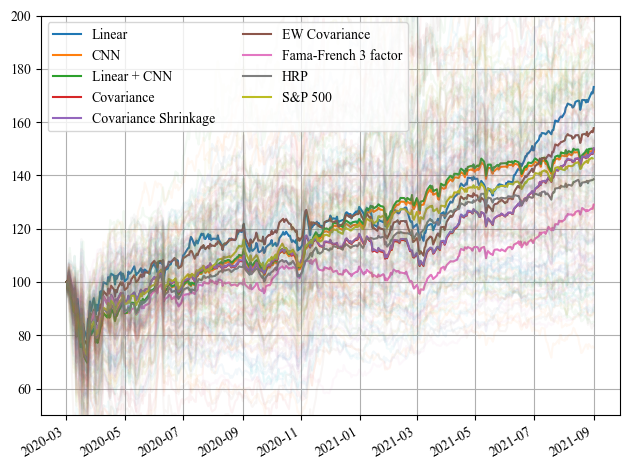

In [10]:
# Plots
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP"]:
    plt.plot(prices_test @ weights[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.plot(prices_test, alpha=0.05)
plt.ylim(50, 200)
plt.grid()
plt.gcf().autofmt_xdate()
plt.legend(ncol=2);

In [11]:
# Sharpe ratio for each model
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP"]:
    print(model, "sharpe",  utils.calculate_sharpe_ratio(prices = prices_test, weights = weights[model]))
print("S&P 500:", utils.calculate_sp500_sharpe(train_date, end_date))

Linear sharpe 1.308656282674764
CNN sharpe 1.048082130539153
Linear + CNN sharpe 1.0579437036283157
Covariance sharpe 1.0288314670579324
Covariance Shrinkage sharpe 1.033495996391961
EW Covariance sharpe 1.1784791655290656
Fama-French 3 factor sharpe 0.7075711367163009
HRP sharpe 0.9342581511901694
S&P 500: 0.06161923672093254


In [12]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP"]:
    print(model, "max drawdown:", utils.calculate_max_drawdown(prices_test, weights[model])*100)
print("S&P 500:", utils.calculate_sp500_drawdown(train_date, end_date))

Linear max drawdown: 22.78912542042094
CNN max drawdown: 31.262767629574718
Linear + CNN max drawdown: 31.155923581293894
Covariance max drawdown: 30.025419595960635
Covariance Shrinkage max drawdown: 29.96767789800085
EW Covariance max drawdown: 24.865873308746732
Fama-French 3 factor max drawdown: 31.391933977086804
HRP max drawdown: 30.842186346854696
S&P 500: 0.2852031811628635


In [13]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP"]:
    print(model, "number of stocks included:", np.count_nonzero(weights[model]))

Linear number of stocks included: 6
CNN number of stocks included: 187
Linear + CNN number of stocks included: 187
Covariance number of stocks included: 10
Covariance Shrinkage number of stocks included: 11
EW Covariance number of stocks included: 9
Fama-French 3 factor number of stocks included: 18
HRP number of stocks included: 187


# Plotting all results

In [14]:
results = {}
for start_date in ["2017-03-01", "2017-09-01", "2018-03-01", "2018-09-01"]:
    results[start_date] = {}
    for opt in ['sharpe', 'volatility']:
   # Open json file with parameters
        with open(f'results/sp500_{start_date}_{opt}.json') as f:
            results[start_date][opt] = json.load(f)['sharpe_ratios']

In [15]:
# convert dict of dicts to dataframe
results_df = pd.DataFrame.from_dict({(i,j): results[i][j]
                           for i in results.keys()
                           for j in results[i].keys()},
                       orient='index')

In [16]:
# Seperate dataframe for when second index is 'sharpe' and 'volatility'
results_sharpe = results_df[results_df.index.get_level_values(1) == 'sharpe'].droplevel(1)
results_volatility = results_df[results_df.index.get_level_values(1) == 'volatility'].droplevel(1)

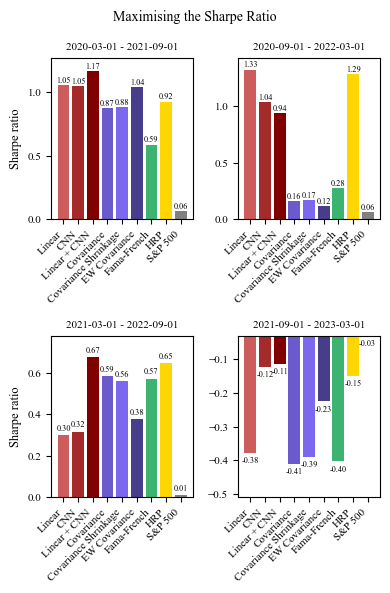

In [19]:
colours = ['indianred', 'brown', 'maroon', 'slateblue', 'mediumslateblue', 'darkslateblue', 'mediumseagreen', 'gold', 'gray']

fig, ax = plt.subplots(2, 2, figsize=(4, 6))
i=0
for date in results_sharpe.index:

    # Calculate test period
    test_start = datetime.strptime(date, '%Y-%m-%d') + relativedelta(years=3)
    test_end = test_start + relativedelta(years=1, months=6)

    # Plotting
    ax.flatten()[i].bar(results_sharpe[results_sharpe.index==date].columns, np.squeeze(results_sharpe[results_sharpe.index==date].values), color = colours)
    plt.setp(ax.flatten()[i].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.flatten()[i].get_yticklabels(), fontsize=8)
    min_y = np.squeeze(results_sharpe[results_sharpe.index==date].values).min()
    max_y = np.squeeze(results_sharpe[results_sharpe.index==date].values).max()
    if min_y<0 and max_y<0:
        max_y-=0.1
        min_y -= 0.1
    elif min_y>0 and max_y>0:
        min_y=0
    ax.flatten()[i].set_ylim(top = max_y+0.1, bottom = min_y)
    ax.flatten()[i].set_title(f"{test_start.strftime('%Y-%m-%d')} - {test_end.strftime('%Y-%m-%d')}", fontsize = 8)

    # Add values to bars
    for j, v in enumerate(np.squeeze(results_sharpe[results_sharpe.index==date].values)):
        if v > 0:
            ax.flatten()[i].text(j, v+0.02, "{:.2f}".format(v), color='black', fontsize=6, ha='center')
        else:
            ax.flatten()[i].text(j, v-0.03, "{:.2f}".format(v), color='black', fontsize=6, ha='center')

    i+=1

ax[0,0].set_ylabel('Sharpe ratio', fontsize=9)
ax[1,0].set_ylabel('Sharpe ratio', fontsize=9)

fig.suptitle('Maximising the Sharpe Ratio', fontsize=10)
fig.tight_layout()

fig.savefig('plots/max_sharpe_results.png')

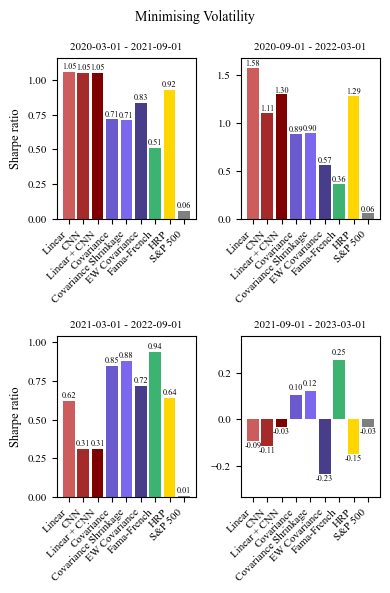

In [20]:
colours = ['indianred', 'brown', 'maroon', 'slateblue', 'mediumslateblue', 'darkslateblue', 'mediumseagreen', 'gold', 'gray']

fig, ax = plt.subplots(2, 2, figsize=(4, 6))
i=0
for date in results_volatility.index:

    # Calculate test period
    test_start = datetime.strptime(date, '%Y-%m-%d') + relativedelta(years=3)
    test_end = test_start + relativedelta(years=1, months=6)

    # Plotting
    ax.flatten()[i].bar(results_volatility[results_volatility.index==date].columns, np.squeeze(results_volatility[results_volatility.index==date].values), color = colours)
    plt.setp(ax.flatten()[i].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.flatten()[i].get_yticklabels(), fontsize=8)
    min_y = np.squeeze(results_volatility[results_volatility.index==date].values).min()
    max_y = np.squeeze(results_volatility[results_volatility.index==date].values).max()
    if (min_y<0) and (max_y<0):
        max_y-=0.1
        min_y -= 0.1
    elif (min_y>0) and (max_y>0):
        min_y=0
    else:
        min_y-=0.1
    ax.flatten()[i].set_ylim(top = max_y+0.1, bottom = min_y)
    ax.flatten()[i].set_title(f"{test_start.strftime('%Y-%m-%d')} - {test_end.strftime('%Y-%m-%d')}", fontsize = 8)

    # Add values to bars
    for j, v in enumerate(np.squeeze(results_volatility[results_volatility.index==date].values)):
        if v > 0:
            ax.flatten()[i].text(j, v+0.02, "{:.2f}".format(v), color='black', fontsize=6, ha='center')
        else:
            ax.flatten()[i].text(j, v-0.03, "{:.2f}".format(v), color='black', fontsize=6, ha='center')

    i+=1

ax[0,0].set_ylabel('Sharpe ratio', fontsize=9)
ax[1,0].set_ylabel('Sharpe ratio', fontsize=9)

fig.suptitle('Minimising Volatility', fontsize=10)
fig.tight_layout()

fig.savefig('plots/min_vol_results.png');